# DDPLKO Moduł 5 - praca domowa - Transfer Learning

To piąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] wybór zbioru danych:
  - [ ] RESISC45 (https://www.tensorflow.org/datasets/catalog/resisc45) - w pytorchu możesz wczytać po rozpakowaniu lub skorzystać z TFDS jak w lekcji (w przypadku ograniczonych zasobów wybierz 10 klas z tego zbioru)
  - [ ] RSCM (http://vcc.szu.edu.cn/research/2017/RSCM.html download link: http://vcc.szu.edu.cn/file/upload_file/0/58/weboem_informations/classification.zip)
  - [ ] własny problem ze zdjeciami (najlepiej) RGB o wymiarach >=224px, minimum 4 klasy, minimum 1000 zdjęć
- [ ] Podziel zbiór w stosunku train:val 70:30 (stratified)
- [ ] Wykonaj krótką prezentację danych - liczebności, przykłady
- [ ] Wybierz framework - TensorFlow bądź PyTorch
- [ ] Wybierz pretrenowany model - skorzystaj z jednego z repozytoriów modeli
- [ ] Zaprezentuj summary dla modelu
- [ ] Przygotuj model - zamroź wagi oprócz klasyfikatora
- [ ] Zaprezentuj summary dla modelu z zamrożonymi wagami
- [ ] W treningach zapisuj wyniki do TensorBoarda
- [ ] Wykonaj trening zamrażając warstwy ekstrkcji cech
- [ ] Wykonaj fine-tuning całej sieci lub większego fragmentu (nie tylko klasyfikator)
- [ ] Udostępnij screenshot z TB na Discordzie `#klasyfikacja-wyniki` (val acc)

Możesz (czyli opcjonalne rzeczy):
- wybrać mały model typu np. MobileNet
- Wykonać eksperymenty i dobrać optymalizator, LR używając LR Finder oraz LR scheduler
- Sprawdzić więcej niż 1 model
- Sprawdzić dodatkowe warstwy Dense/Linear w klasyfikatorze
- Spróbować treningu bez transfer learningu
- zwizualizować dodatkowo:
  - confussion matrix
  - błędne przypadki

In [1]:
# z lekcji 5.04

import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import models, datasets
from torchvision import transforms as T
from torch import nn
import torch

import tensorflow as tf
import tensorflow_datasets as tfds

#!pip install timm
import timm

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Zbiór danych

In [2]:
(ds_train, ds_val),info = tfds.load(
    "resisc45",
    split=["train[:70%]", "train[70%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 22050
Val: 9450


## Podział zbioru

## Wizualizacja danych

In [3]:
class_names = info.features['label'].names
for c in class_names:
    print(c)

airplane
airport
baseball_diamond
basketball_court
beach
bridge
chaparral
church
circular_farmland
cloud
commercial_area
dense_residential
desert
forest
freeway
golf_course
ground_track_field
harbor
industrial_area
intersection
island
lake
meadow
medium_residential
mobile_home_park
mountain
overpass
palace
parking_lot
railway
railway_station
rectangular_farmland
river
roundabout
runway
sea_ice
ship
snowberg
sparse_residential
stadium
storage_tank
tennis_court
terrace
thermal_power_station
wetland


In [4]:
num_classes = len(class_names)
num_classes

45

2 (256, 256, 3) tf.Tensor(11, shape=(), dtype=int64)


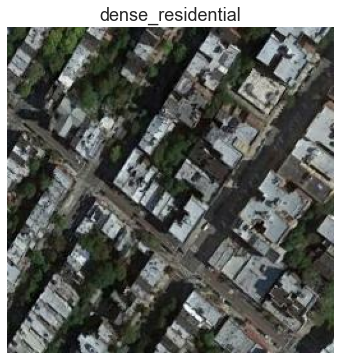

In [5]:
plt.figure(figsize=(6,6))
for i,_ in enumerate(ds_train.take(1)):
    print(len(_),_[0].shape,_[1])
    plt.imshow(_[0])
    plt.title(class_names[_[1]])
    plt.axis('off')

2 (256, 256, 3) tf.Tensor(11, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(41, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(34, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(1, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(6, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(7, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(8, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(15, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(25, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(26, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(22, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(27, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(44, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(39, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(31, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(37, shape=(), dtype=int64)
2 (256, 256, 3) tf.Tensor(9, shape=(), dtype=int64

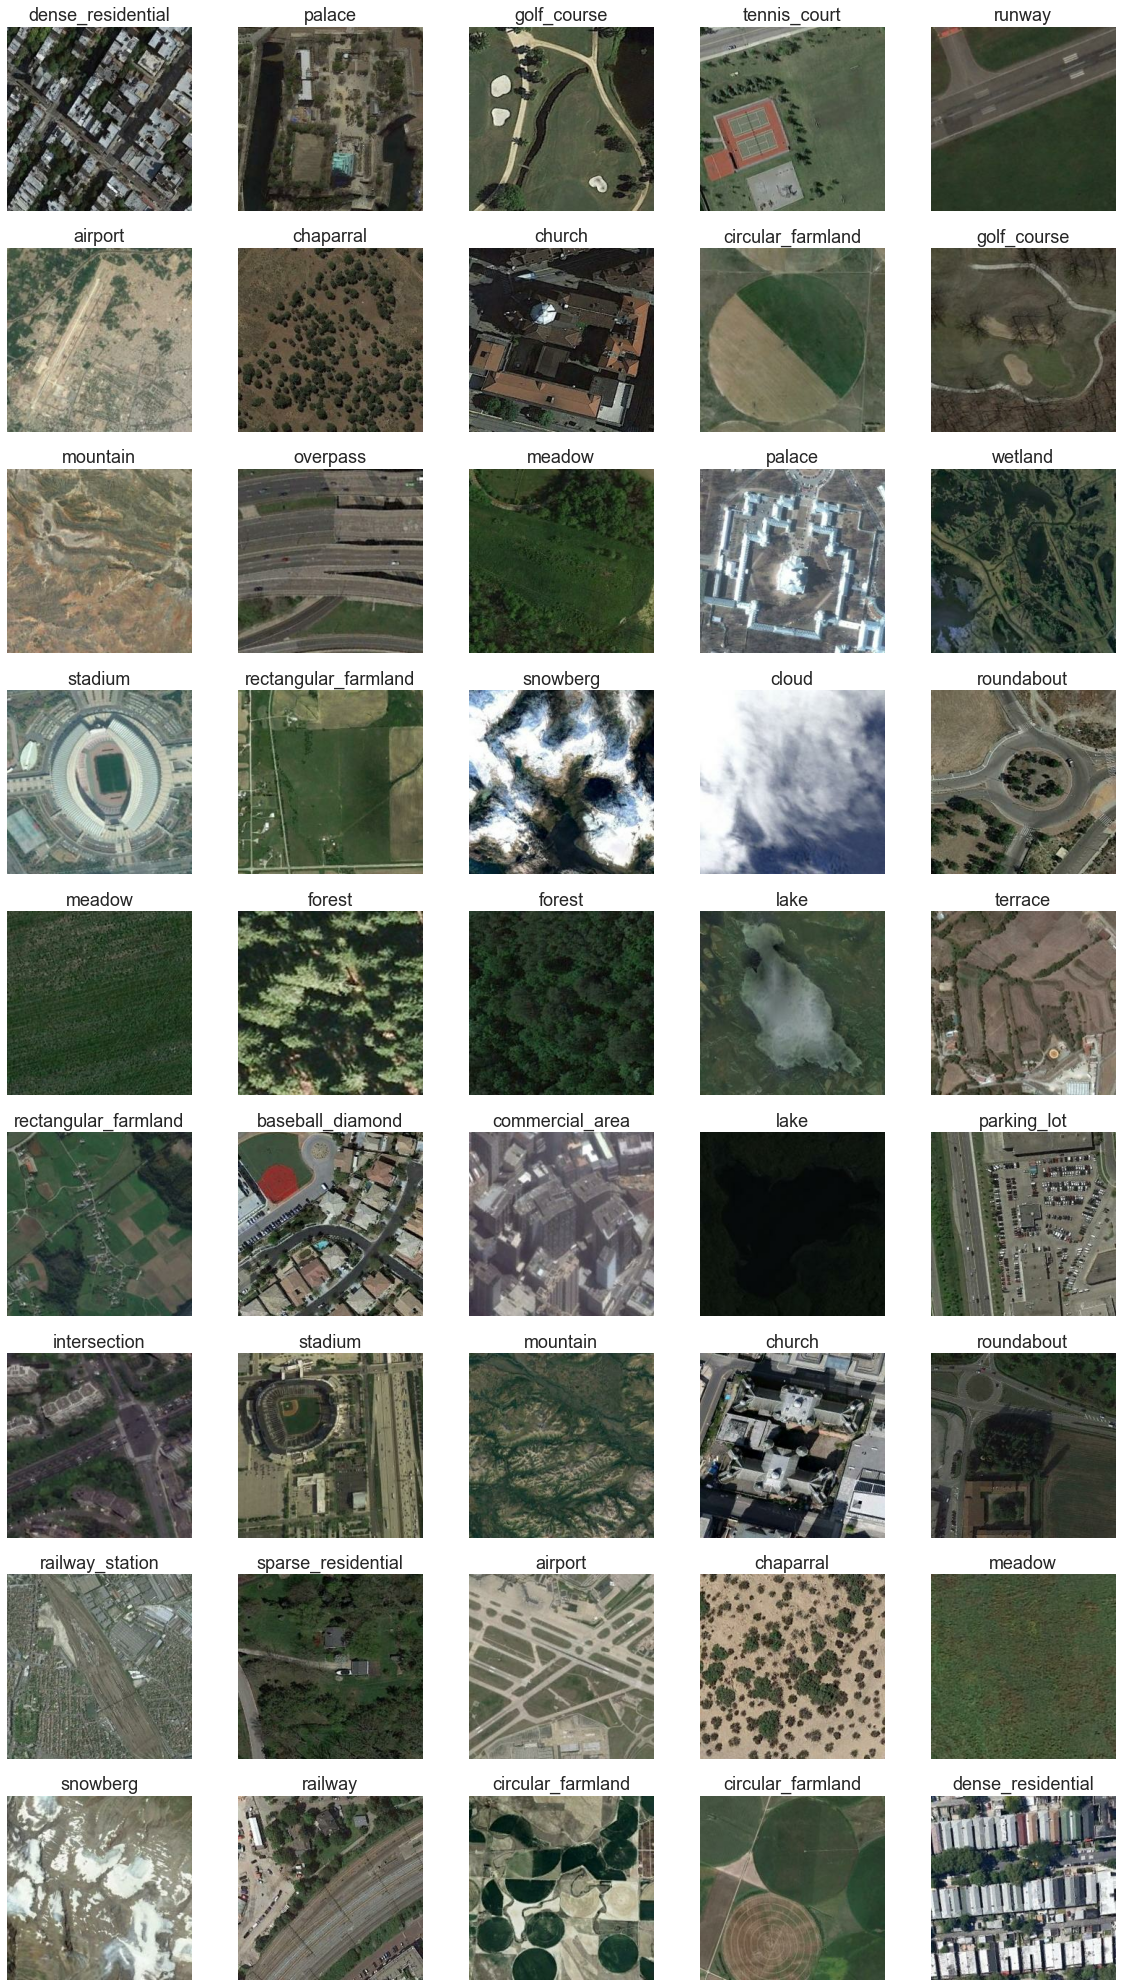

In [6]:
plt.figure(figsize=(20,40))
for i,_ in enumerate(ds_train.take(45)):
    print(len(_),_[0].shape,_[1])
    plt.subplot(10,5,i+1)
    plt.imshow(_[0])
    plt.title(class_names[_[1]])
    plt.axis('off')

In [7]:
img_size = 224 # EffNet B0
batch_size=32

size = (img_size, img_size)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

## Model z lekcji 5.04

In [8]:
model = tf.keras.applications.EfficientNetB0(include_top=True, weights=None, classes=len(class_names),input_shape=(img_size,img_size,3))
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [9]:
epochs = 30
history_scratch = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/30
689/689 [==============================] - 1878s 3s/step - loss: 2.9821 - accuracy: 0.2061 - val_loss: 2.7282 - val_accuracy: 0.2304
Epoch 2/30
689/689 [==============================] - 1863s 3s/step - loss: 2.0796 - accuracy: 0.3988 - val_loss: 1.8807 - val_accuracy: 0.4482
Epoch 3/30
689/689 [==============================] - 1895s 3s/step - loss: 1.6201 - accuracy: 0.5251 - val_loss: 1.5145 - val_accuracy: 0.5492
Epoch 4/30
689/689 [==============================] - 1886s 3s/step - loss: 1.3199 - accuracy: 0.6001 - val_loss: 1.4584 - val_accuracy: 0.5711
Epoch 5/30
689/689 [==============================] - 1917s 3s/step - loss: 1.0805 - accuracy: 0.6680 - val_loss: 4.5246 - val_accuracy: 0.5082
Epoch 6/30
689/689 [==============================] - 1915s 3s/step - loss: 0.8623 - accuracy: 0.7311 - val_loss: 1.5664 - val_accuracy: 0.5908
Epoch 7/30
689/689 [==============================] - 1900s 3s/step - loss: 0.6830 - accuracy: 0.7808 - val_loss: 1.4872 - val_accuracy:

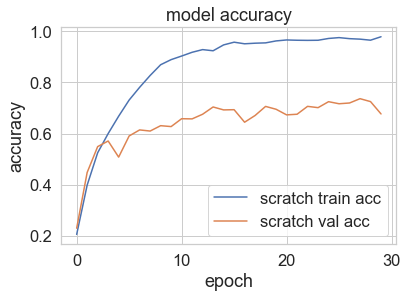

In [10]:
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [11]:
def build_model(img_size,num_classes):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze imagenet pretrained weights
    base_model.trainable = False

    # New top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

model = build_model(img_size=img_size, num_classes=len(class_names))
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [12]:
epochs = 10
history_freeze = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 554s 800ms/step - loss: 1.4626 - accuracy: 0.7135 - val_loss: 0.7400 - val_accuracy: 0.8179
Epoch 2/10
689/689 [==============================] - 549s 797ms/step - loss: 0.6751 - accuracy: 0.8180 - val_loss: 0.6874 - val_accuracy: 0.8242
Epoch 3/10
689/689 [==============================] - 549s 797ms/step - loss: 0.6201 - accuracy: 0.8262 - val_loss: 0.7078 - val_accuracy: 0.8246
Epoch 4/10
689/689 [==============================] - 550s 798ms/step - loss: 0.6182 - accuracy: 0.8316 - val_loss: 0.6900 - val_accuracy: 0.8346
Epoch 5/10
689/689 [==============================] - 550s 798ms/step - loss: 0.6609 - accuracy: 0.8321 - val_loss: 0.7884 - val_accuracy: 0.8269
Epoch 6/10
689/689 [==============================] - 550s 798ms/step - loss: 0.6810 - accuracy: 0.8317 - val_loss: 0.8589 - val_accuracy: 0.8212
Epoch 7/10
689/689 [==============================] - 548s 796ms/step - loss: 0.7025 - accuracy: 0.8322 - val_loss: 0.8736 -

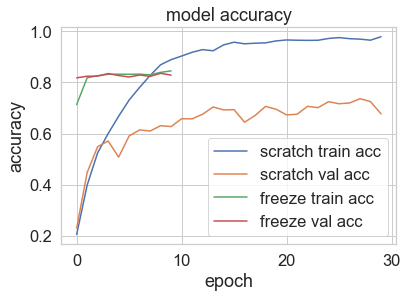

In [13]:
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.plot(history_freeze.history["accuracy"], label='freeze train acc')
plt.plot(history_freeze.history["val_accuracy"], label='freeze val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [14]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [15]:
epochs = 10
history_unfreeze = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 596s 861ms/step - loss: 0.4381 - accuracy: 0.8935 - val_loss: 0.5883 - val_accuracy: 0.8817
Epoch 2/10
689/689 [==============================] - 592s 859ms/step - loss: 0.2591 - accuracy: 0.9269 - val_loss: 0.5701 - val_accuracy: 0.8852
Epoch 3/10
689/689 [==============================] - 591s 859ms/step - loss: 0.1812 - accuracy: 0.9448 - val_loss: 0.5391 - val_accuracy: 0.8929
Epoch 4/10
689/689 [==============================] - 592s 859ms/step - loss: 0.1443 - accuracy: 0.9553 - val_loss: 0.5179 - val_accuracy: 0.8923
Epoch 5/10
689/689 [==============================] - 592s 860ms/step - loss: 0.1145 - accuracy: 0.9630 - val_loss: 0.4890 - val_accuracy: 0.8993
Epoch 6/10
689/689 [==============================] - 592s 860ms/step - loss: 0.0945 - accuracy: 0.9691 - val_loss: 0.4952 - val_accuracy: 0.9019
Epoch 7/10
689/689 [==============================] - 592s 859ms/step - loss: 0.0808 - accuracy: 0.9731 - val_loss: 0.5080 -

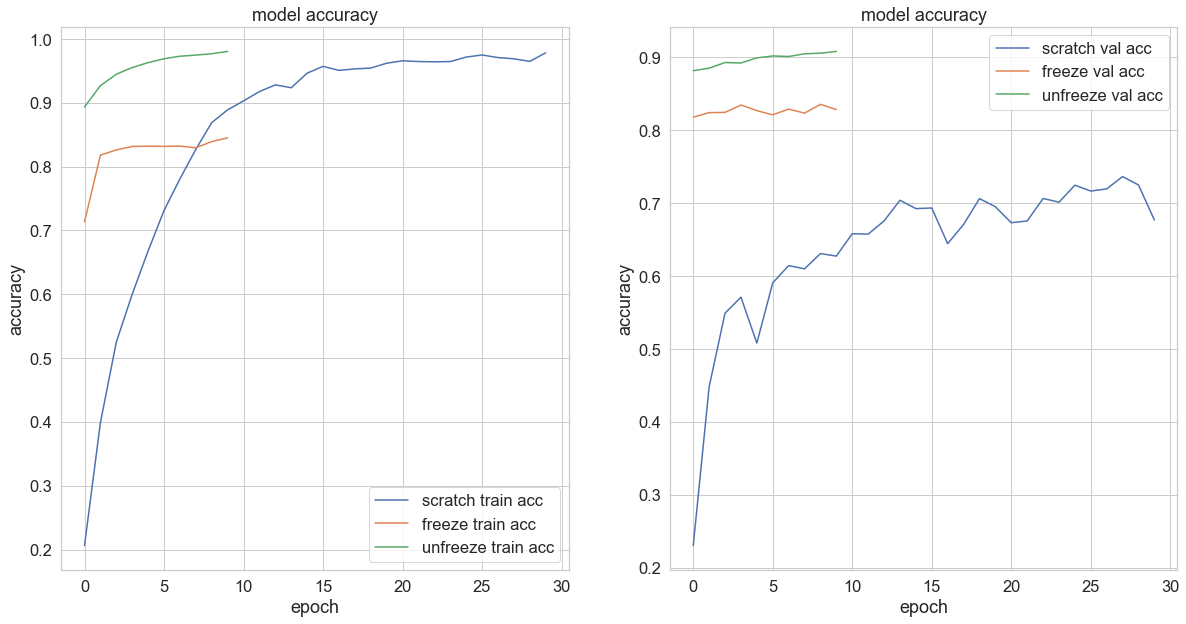

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_freeze.history["accuracy"], label='freeze train acc')
plt.plot(history_unfreeze.history["accuracy"], label='unfreeze train acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.subplot(122)
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.plot(history_freeze.history["val_accuracy"], label='freeze val acc')
plt.plot(history_unfreeze.history["val_accuracy"], label='unfreeze val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

# Model

## Wybór modelu + summary

In [17]:
# https://keras.io/api/applications/inceptionv3/

model = tf.keras.applications.InceptionV3(include_top=True, weights=None, classes=len(class_names),input_shape=(img_size,img_size,3))
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

## Freezed model + summary

In [18]:
def build_model(img_size,num_classes):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    base_model = tf.keras.applications.InceptionV3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze imagenet pretrained weights
    base_model.trainable = False

    # New top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

model = build_model(img_size=img_size, num_classes=len(class_names))
model.summary()

87924736/87910968 [==============================] - 35s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
_____________________

# Training

In [25]:
# zmniejszyłam liczbę epok do 15

epochs = 15
history_scratch = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/15
689/689 [==============================] - 491s 709ms/step - loss: 4.1197 - accuracy: 0.2313 - val_loss: 2.5769 - val_accuracy: 0.2959
Epoch 2/15
689/689 [==============================] - 488s 708ms/step - loss: 2.5872 - accuracy: 0.3066 - val_loss: 2.5662 - val_accuracy: 0.3037
Epoch 3/15
689/689 [==============================] - 492s 714ms/step - loss: 2.5626 - accuracy: 0.3114 - val_loss: 2.5905 - val_accuracy: 0.3007
Epoch 4/15
689/689 [==============================] - 490s 712ms/step - loss: 2.5676 - accuracy: 0.3127 - val_loss: 2.6191 - val_accuracy: 0.2980
Epoch 5/15
689/689 [==============================] - 489s 710ms/step - loss: 2.5895 - accuracy: 0.3108 - val_loss: 2.6465 - val_accuracy: 0.2943
Epoch 6/15
689/689 [==============================] - 479s 695ms/step - loss: 2.6081 - accuracy: 0.3067 - val_loss: 2.6797 - val_accuracy: 0.2933
Epoch 7/15
689/689 [==============================] - 485s 704ms/step - loss: 2.6217 - accuracy: 0.3071 - val_loss: 2.6780 -

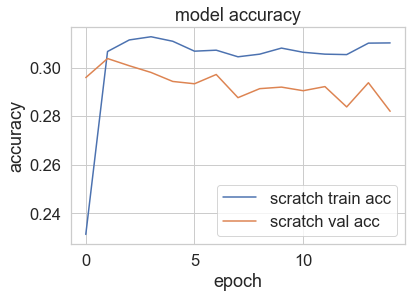

In [26]:
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

## Training freezed model

In [27]:
epochs = 10
history_freeze = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 477s 692ms/step - loss: 2.6600 - accuracy: 0.3087 - val_loss: 2.8270 - val_accuracy: 0.2908
Epoch 2/10
689/689 [==============================] - 477s 692ms/step - loss: 2.6667 - accuracy: 0.3057 - val_loss: 2.8102 - val_accuracy: 0.2910
Epoch 3/10
689/689 [==============================] - 477s 693ms/step - loss: 2.6506 - accuracy: 0.3088 - val_loss: 2.7866 - val_accuracy: 0.2890
Epoch 4/10
689/689 [==============================] - 477s 693ms/step - loss: 2.6507 - accuracy: 0.3114 - val_loss: 2.7658 - val_accuracy: 0.2964
Epoch 5/10
689/689 [==============================] - 478s 695ms/step - loss: 2.6564 - accuracy: 0.3073 - val_loss: 2.8275 - val_accuracy: 0.2870
Epoch 6/10
689/689 [==============================] - 487s 707ms/step - loss: 2.6625 - accuracy: 0.3095 - val_loss: 2.8158 - val_accuracy: 0.2859
Epoch 7/10
689/689 [==============================] - 492s 714ms/step - loss: 2.6442 - accuracy: 0.3110 - val_loss: 2.7827 -

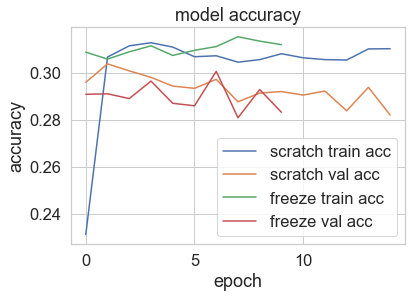

In [28]:
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.plot(history_freeze.history["accuracy"], label='freeze train acc')
plt.plot(history_freeze.history["val_accuracy"], label='freeze val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

## Unfreeze model

In [29]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [30]:
epochs = 10
history_unfreeze = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 507s 731ms/step - loss: 2.3444 - accuracy: 0.3668 - val_loss: 2.4291 - val_accuracy: 0.3382
Epoch 2/10
689/689 [==============================] - 504s 731ms/step - loss: 2.1763 - accuracy: 0.3990 - val_loss: 2.3732 - val_accuracy: 0.3555
Epoch 3/10
689/689 [==============================] - 509s 740ms/step - loss: 2.0844 - accuracy: 0.4143 - val_loss: 2.3366 - val_accuracy: 0.3664
Epoch 4/10
689/689 [==============================] - 505s 733ms/step - loss: 2.0005 - accuracy: 0.4387 - val_loss: 2.3090 - val_accuracy: 0.3714
Epoch 5/10
689/689 [==============================] - 502s 729ms/step - loss: 1.9287 - accuracy: 0.4571 - val_loss: 2.3000 - val_accuracy: 0.3737
Epoch 6/10
689/689 [==============================] - 506s 735ms/step - loss: 1.8566 - accuracy: 0.4730 - val_loss: 2.2917 - val_accuracy: 0.3805
Epoch 7/10
689/689 [==============================] - 506s 735ms/step - loss: 1.7912 - accuracy: 0.4929 - val_loss: 2.2976 -

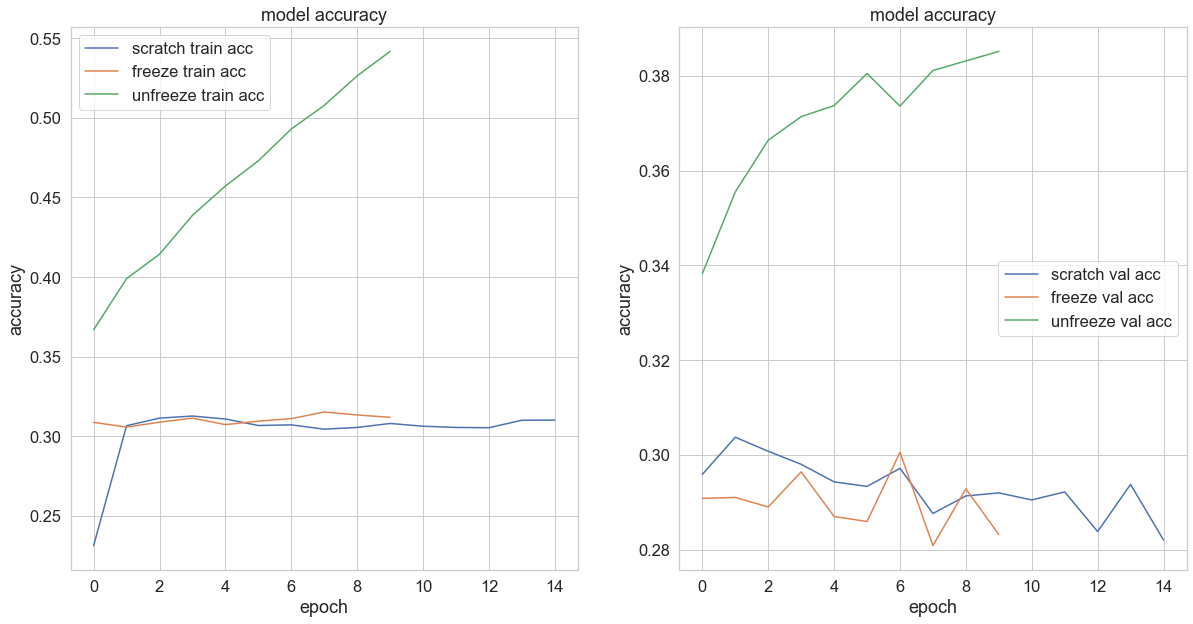

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(history_scratch.history["accuracy"], label='scratch train acc')
plt.plot(history_freeze.history["accuracy"], label='freeze train acc')
plt.plot(history_unfreeze.history["accuracy"], label='unfreeze train acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.subplot(122)
plt.plot(history_scratch.history["val_accuracy"], label='scratch val acc')
plt.plot(history_freeze.history["val_accuracy"], label='freeze val acc')
plt.plot(history_unfreeze.history["val_accuracy"], label='unfreeze val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

## Fine tuning

In [8]:
# tutaj się trochę pobawiłam parametrami modelu niekoniecznie to poprawilo wynik

def tuned_model(img_size,num_classes):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    base_model = tf.keras.applications.InceptionV3(include_top=False, input_tensor=inputs, weights="imagenet")

    # New top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.02, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="relu", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

model = tuned_model(img_size=img_size, num_classes=len(class_names))
model.summary()
    

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
epochs = 10
history_tuning = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 3983s 6s/step - loss: 4.1436 - accuracy: 0.1743 - val_loss: 3.9351 - val_accuracy: 0.2057
Epoch 2/10
689/689 [==============================] - 4010s 6s/step - loss: 4.1116 - accuracy: 0.1659 - val_loss: 4.4241 - val_accuracy: 0.1832
Epoch 3/10
689/689 [==============================] - 3983s 6s/step - loss: 3.8971 - accuracy: 0.1817 - val_loss: 4.6307 - val_accuracy: 0.2124
Epoch 4/10
689/689 [==============================] - 3927s 6s/step - loss: 4.2347 - accuracy: 0.0938 - val_loss: 4.1179 - val_accuracy: 0.0651
Epoch 5/10
689/689 [==============================] - 3929s 6s/step - loss: 4.1227 - accuracy: 0.0725 - val_loss: 4.4959 - val_accuracy: 0.0839
Epoch 6/10
689/689 [==============================] - 3902s 6s/step - loss: 4.2216 - accuracy: 0.0671 - val_loss: 4.5193 - val_accuracy: 0.0660
Epoch 7/10
689/689 [==============================] - 3829s 6s/step - loss: 4.1362 - accuracy: 0.0679 - val_loss: 4.4290 - val_accuracy:

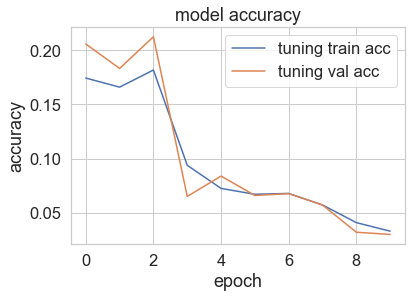

In [11]:
plt.plot(history_tuning.history["accuracy"], label='tuning train acc')
plt.plot(history_tuning.history["val_accuracy"], label='tuning val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

# Summmary / extra

## Model Xception

Według tabelki na stronie: https://keras.io/api/applications/ jest na samej górze (top accuracy)

https://keras.io/api/applications/xception/

In [12]:
model = tf.keras.applications.Xception(include_top=True, weights=None, classes=len(class_names),input_shape=(img_size,img_size,3))
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
epochs = 10
history_scratch = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/10
689/689 [==============================] - 7560s 11s/step - loss: 2.3610 - accuracy: 0.3412 - val_loss: 3.6779 - val_accuracy: 0.2881
Epoch 2/10
689/689 [==============================] - 4227s 6s/step - loss: 1.4226 - accuracy: 0.5798 - val_loss: 5.0279 - val_accuracy: 0.3331
Epoch 3/10
689/689 [==============================] - 4056s 6s/step - loss: 0.9854 - accuracy: 0.6985 - val_loss: 2.1641 - val_accuracy: 0.5089
Epoch 4/10
689/689 [==============================] - 4050s 6s/step - loss: 0.6905 - accuracy: 0.7824 - val_loss: 2.2986 - val_accuracy: 0.5018
Epoch 5/10
689/689 [==============================] - 4054s 6s/step - loss: 0.4774 - accuracy: 0.8485 - val_loss: 2.8135 - val_accuracy: 0.4914
Epoch 6/10
689/689 [==============================] - 4047s 6s/step - loss: 0.3290 - accuracy: 0.8930 - val_loss: 4.0255 - val_accuracy: 0.4376
Epoch 7/10
689/689 [==============================] - 4033s 6s/step - loss: 0.2485 - accuracy: 0.9199 - val_loss: 1.9431 - val_accuracy

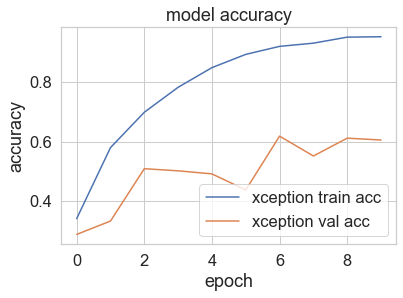

In [14]:
plt.plot(history_scratch.history["accuracy"], label='xception train acc')
plt.plot(history_scratch.history["val_accuracy"], label='xception val acc')
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()